In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 30 12:22:07 2018

@author: Gaspare
"""

from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

## Config the matplotlib backend as plotting inline in IPython
#%matplotlib inline


url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)





Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


In [2]:
%matplotlib inline

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


In [4]:
##Problem 1
#Let's take a peek at some of the data to make sure it looks sensible.
#Each exemplar should be an image of a character A through J rendered in a different font.
#Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.


for folder in train_folders:
    print(folder)
    image_files=os.listdir(folder)
    display(Image(filename=folder+'\\'+image_files[int(np.random.randint(5000,size=1))]))
    display(Image(filename=folder+'\\'+image_files[int(np.random.randint(5000,size=1))]))
    display(Image(filename=folder+'\\'+image_files[int(np.random.randint(5000,size=1))]))

.\notMNIST_large\A


.\notMNIST_large\B


.\notMNIST_large\C


.\notMNIST_large\D


.\notMNIST_large\E


.\notMNIST_large\F


.\notMNIST_large\G


.\notMNIST_large\H


.\notMNIST_large\I


.\notMNIST_large\J


In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

Total images in .\notMNIST_small\A.pickle : 1872
1872
Total images in .\notMNIST_small\B.pickle : 1873
1873
Total images in .\notMNIST_small\C.pickle : 1873
1873
Total images in .\notMNIST_small\D.pickle : 1873
1873
Total images in .\notMNIST_small\E.pickle : 1873
1873
Total images in .\notMNIST_small\F.pickle : 1872
1872
Total images in .\notMNIST_small\G.pickle : 1872
1872
Total images in .\notMNIST_small\H.pickle : 1872
1872
Total images in .\notMNIST_small\I.pickle : 1872
1872
Total images in .\notMNIST_small\J.pickle : 1872
1872


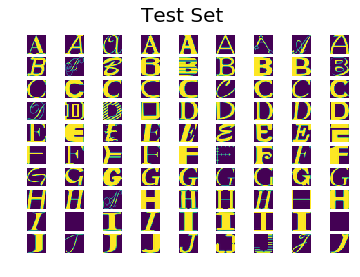

mean size of the dataset is 1872
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Total images in .\notMNIST_large\A.pickle : 52909
52909
Total images in .\notMNIST_large\B.pickle : 52911
52911
Total images in .\notMNIST_large\C.pickle : 52912
52912
Total images in .\notMNIST_large\D.pickle : 52911
52911
Total images in .\notMNIST_large\E.pickle : 52912
52912
Total images in .\notMNIST_large\F.pickle : 52912
52912
Total images in .\notMNIST_large\G.pickle : 52912
52912
Total images in .\notMNIST_large\H.pickle : 52912
52912
Total images in .\notMNIST_large\I.pickle : 52912
52912
Total images in .\notMNIST_large\J.pickle : 52911
52911


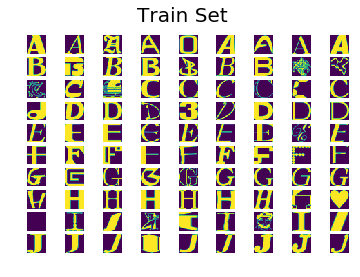

mean size of the dataset is 52911
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data
Balanced data


In [79]:
#Problem 2: Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. 
#Problem 3:Another check: we expect the data to be balanced across classes. Verify that.



def mean(numbers):
    #mean function
    return float(sum(numbers)) / max(len(numbers), 1)


def balance_check(data):
    mean_size=mean(data)
    print("mean size of the dataset is %.0f" % mean_size)
    #check if size of a letter is unbalanced with respect to the mean size
    for letter in data:
        if abs(letter - mean_size)>0.1*mean_size:
            print("Unbalanced data")
        else:
            print("Balanced data")



def read_pickle(datasets, sample_size, title):
    size_dataset=[]
    fig=plt.figure()
    fig.suptitle(title, fontsize=20)
    #load pickles files
    for pickle_file in datasets:
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
            print('Total images in', pickle_file, ':', len(data))
            size_dataset.append(len(data))
            #print randomly a sample of data
            index=0
            for i in range(0,sample_size):
                ax = fig.add_subplot(len(datasets), sample_size, sample_size * datasets.index(pickle_file) +
                                     index + 1)
                index=index+1
                ax.imshow(data[int(np.random.randint(len(data),size=1))])
                ax.set_axis_off()
                ax.imshow(data[int(np.random.randint(len(data),size=1))])
                     

        print(len(data))
    
    plt.show()
    
    return size_dataset
          
        
        
        
        
balance_check(read_pickle(test_datasets,9,'Test Set'))
balance_check(read_pickle(train_datasets,9,'Train Set'))


In [5]:
#Merge and prune the training data as needed. Depending on your computer setup, 
#you might not be able to fit it all in memory, and you can tune train_size as needed.
#The labels will be stored into a separate array of integers 0 through 9.
#Also create a validation dataset for hyperparameter tuning.

def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [6]:
#Next, we'll randomize the data. It's important to have the labels well shuffled
#for the training and test distributions to match.


def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

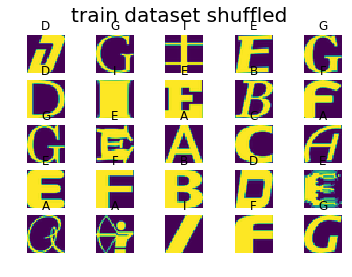

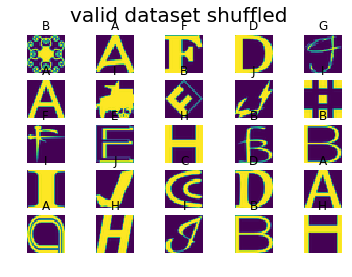

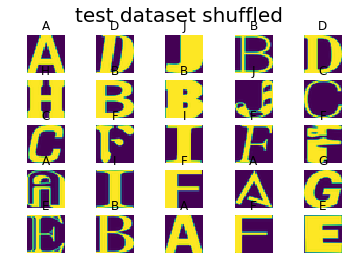

In [12]:
#Convince yourself that the data is still good after shuffling!


import random

def plot_dataset(dataset, label, title):
    fig=plt.figure()
    fig.suptitle(title, fontsize=20)
    #select a random sample of data
    data=random.sample(range(len(label)),25)
    for key,item in enumerate(data):
        plt.subplot(5,5,key+1)
        plt.axis('off')
        plt.title(chr(ord('A') + label[item]))
        plt.imshow(dataset[item])
    
    plt.show()
    
plot_dataset(train_dataset, train_labels, 'train dataset shuffled')
plot_dataset(valid_dataset, valid_labels, 'valid dataset shuffled')
plot_dataset(test_dataset, test_labels, 'test dataset shuffled')

In [7]:
#Finally, let's save the data for later reuse:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


In [8]:
#Measure how much overlap there is between training, validation and test samples.
import hashlib

def get_hash(dataset):
    return np.array([hashlib.sha256(img).hexdigest() for img in dataset])

def overlap2d(dataset1, dataset2):
    dataset_hash1=get_hash(dataset1)
    dataset_hash2=get_hash(dataset2)
    overlaps={}
    i=0
    for key, value in enumerate(dataset_hash1):
        duplicates=np.where(dataset_hash2==value)
        if len(duplicates[0])>0:
            overlaps[i]=duplicates[0]
            i=i+1
    return overlaps

test_train_overlap=overlap2d(test_dataset, train_dataset)
print('Number of overlaps between train and test sets is %0.f' % len(test_train_overlap))
        


Number of overlaps between train and test sets is 1324


In [26]:
#What about near duplicates between datasets? (images that are almost identical)



In [13]:
#Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments

def sanitize(ref_dataset,san_dataset, san_labels):
    ref_dataset_hash=get_hash(ref_dataset)
    san_dataset_hash=get_hash(san_dataset)
    sanitazed=[]
    #append indexes of duplicates
    for key, value in enumerate(san_dataset_hash):
        duplicates=np.where(ref_dataset_hash==value)
        if len(duplicates[0])>0:
            sanitazed.append(key)
    
    return np.delete(san_dataset, sanitazed, axis=0), np.delete(san_labels, sanitazed,None)

test_dataset_sanitized, test_labels_sanitized=sanitize(train_dataset, test_dataset, test_labels)
print('dupicates deleted from test set %.0f' % (len(test_dataset) -len(test_dataset_sanitized)))

valid_dataset_sanitized, valid_labels_sanitized=sanitize(train_dataset, valid_dataset, valid_labels)
print('dupicates deleted from test set %.0f' % (len(valid_dataset) -len(valid_dataset_sanitized)))

dupicates deleted from test set 1324
dupicates deleted from test set 1067


In [14]:
#save the sanitized version

pickle_file = os.path.join(data_root, 'Sanitized_notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset_sanitized,
    'valid_labels': valid_labels_sanitized,
    'test_dataset': test_dataset_sanitized,
    'test_labels': test_labels_sanitized,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)


Compressed pickle size: 683292766


In [42]:
#Train a simple model on this data using 50, 100, 1000 and 5000 training samples
from sklearn.linear_model import LogisticRegression


def LR_classifier(size):
    classifier=LogisticRegression()
    X_train=train_dataset[0:size,:,:]
    X_train = X_train.reshape((size,image_size*image_size))
    y_train=train_labels[0:size]
    classifier.fit(X_train, y_train)
    
    X_test=test_dataset.reshape(test_dataset.shape[0],image_size*image_size)
    y_test=test_labels
    
    print('Accuracy: %.2f' %( classifier.score(X_test,y_test)), 'with sample size of :', size)
    

for size in [50, 100, 1000, 5000, len(train_dataset)]:
    LR_classifier(size)

Accuracy: 0.51 with sample size of : 50
Accuracy: 0.70 with sample size of : 100
Accuracy: 0.83 with sample size of : 1000
Accuracy: 0.85 with sample size of : 5000
Accuracy: 0.89 with sample size of : 200000
